In [2]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-<torch_version>+cu<cuda_version>.html

/bin/bash: line 1: torch_version: No such file or directory


In [3]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv \
  -f https://data.pyg.org/whl/torch-<torch_version>+cpu.html


/bin/bash: line 1: torch_version: No such file or directory


In [5]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv \
  -f https://data.pyg.org/whl/torch-2.0.1+cu118.html


Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00


In [7]:
class CNNBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(CNNBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, output_channels, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x


In [8]:
cnn_input_channels = 8  # Update input channels to match the data
model = NavierStokesNet(cnn_input_channels, gnn_input_dim, gnn_hidden_dim, gnn_output_dim)


In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

# Load dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]  # Use the first graph in the dataset

# Get node features and edge index
node_features = data.x  # Node feature matrix (2708 nodes, 1433 features)
edge_index = data.edge_index  # Graph connectivity

# Define a simple GNN model
class GNNBlock(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GNNBlock, self).__init__()
        self.conv1 = GCNConv(input_dim, output_dim)

    def forward(self, x, edge_index):
        return F.relu(self.conv1(x, edge_index))

# Instantiate the model with the correct input dimension
input_dim = node_features.shape[1]  # 1433 features
output_dim = 128
model = GNNBlock(input_dim=input_dim, output_dim=output_dim)

# Forward pass
output = model(node_features, edge_index)

print("Output shape:", output.shape)  # Should show (2708, 128)


Output shape: torch.Size([2708, 128])


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model class (NavierStokesNet)
class NavierStokesNet(nn.Module):
    def __init__(self):
        super(NavierStokesNet, self).__init__()

        # Define layers (e.g., fully connected layers, or graph neural network layers)
        # Example: simple 2-layer feed-forward network
        self.fc1 = nn.Linear(5, 64)  # Assuming 5 features per node
        self.fc2 = nn.Linear(64, 1)  # Assuming 1 output per node (for regression)

    def forward(self, node_features, edge_index):
        # Forward pass through the layers
        x = torch.relu(self.fc1(node_features))
        x = self.fc2(x)
        return x

# Training function
# Training function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    # Loop through batches in the dataloader
    for batch in dataloader:
        # Print the batch to inspect its structure
        print(f"Batch content: {batch}")  # This will print the entire batch structure

        # Assuming the batch contains 3 elements: node_features, edge_index, and targets
        if isinstance(batch, list):
            print(f"Batch contains {len(batch)} elements")  # This will show how many elements are in the batch

            if len(batch) == 3:  # Adjusting to 3 elements
                node_features, edge_index, targets = batch
            else:
                raise ValueError(f"Unexpected number of elements in batch list: {len(batch)}")
        else:
            raise ValueError(f"Batch format not recognized: {type(batch)}")

        # Ensure node_features, edge_index, and targets are tensors
        if not isinstance(node_features, torch.Tensor) or not isinstance(edge_index, torch.Tensor) or not isinstance(targets, torch.Tensor):
            raise ValueError("Node features, edge index, or targets are not tensors.")

        # Move the data to the specified device (CPU or GPU)
        node_features = node_features.to(device)
        edge_index = edge_index.to(device)
        targets = targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: pass both node_features and edge_index to the model
        outputs = model(node_features, edge_index)

        # Calculate the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track running loss
        running_loss += loss.item()

    return running_loss / len(dataloader)


# Sample data loader (replace with your actual data loader)
class ExampleDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = [
            (torch.randn(10, 5), torch.randint(0, 10, (2, 15)), torch.randn(10, 1)),
            (torch.randn(10, 5), torch.randint(0, 10, (2, 15)), torch.randn(10, 1)),
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Initialize model, optimizer, and loss function
model = NavierStokesNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Example dataloader
dataloader = torch.utils.data.DataLoader(ExampleDataset(), batch_size=2, shuffle=True)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Should not raise error now
criterion = nn.MSELoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    loss = train(model, dataloader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")


Batch content: [tensor([[[ 0.7851,  0.3859,  0.7744, -0.3717, -0.3484],
         [-0.1435, -0.7285,  0.5885,  0.0199,  0.5570],
         [ 0.0488,  0.2518, -0.2674, -0.6114, -0.2964],
         [ 0.3831,  0.5674, -2.8543, -2.6139,  0.5766],
         [ 0.8547, -0.6534, -0.4279, -0.6592, -0.0215],
         [-0.0047, -0.2948,  0.7287,  0.0159, -0.6941],
         [-1.6375,  1.0075, -0.3826,  1.3536, -0.2764],
         [-1.0892, -1.6508,  0.0240,  0.0926,  0.5615],
         [ 0.2926, -0.6895,  1.1105,  0.9949, -1.6149],
         [ 1.8543, -0.5108,  0.4175, -1.6722,  0.7634]],

        [[-2.0694, -0.2149, -2.0506,  1.2038, -0.1480],
         [-1.5639, -0.0849,  0.2208,  0.1220,  1.0932],
         [-0.4214, -0.3757, -0.2546,  0.9361, -0.7638],
         [-0.3550, -1.2104,  0.7712, -0.3086, -1.1178],
         [ 1.2966,  0.2215, -0.1403,  1.3960,  0.1948],
         [-0.3182, -1.0690, -0.0792,  1.4776, -0.1080],
         [ 0.1508,  1.1440, -0.3769, -0.2717, -1.7164],
         [-1.3825,  1.4629, -0

Epoch 1/10, Loss: 0.9925
Epoch 2/10, Loss: 1.0701
Epoch 3/10, Loss: 1.1150
Epoch 4/10, Loss: 0.8381
Epoch 5/10, Loss: 0.9292
Epoch 6/10, Loss: 1.0423
Epoch 7/10, Loss: 1.0494
Epoch 8/10, Loss: 0.7693
Epoch 9/10, Loss: 0.7653
Epoch 10/10, Loss: 0.9861


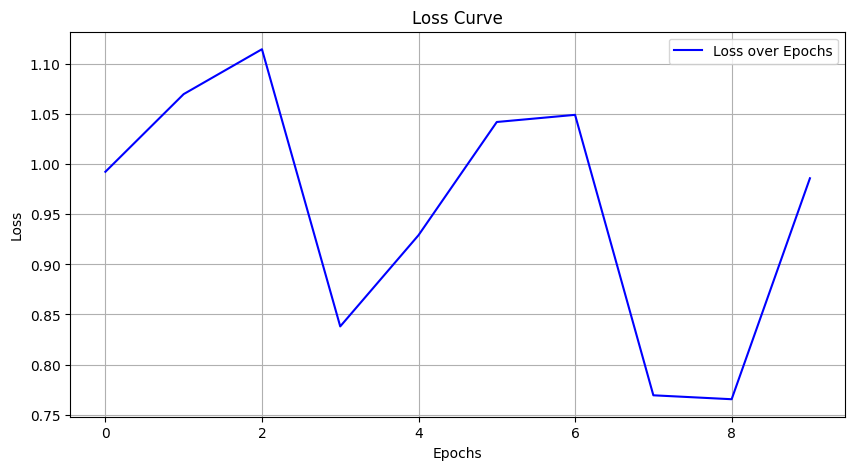

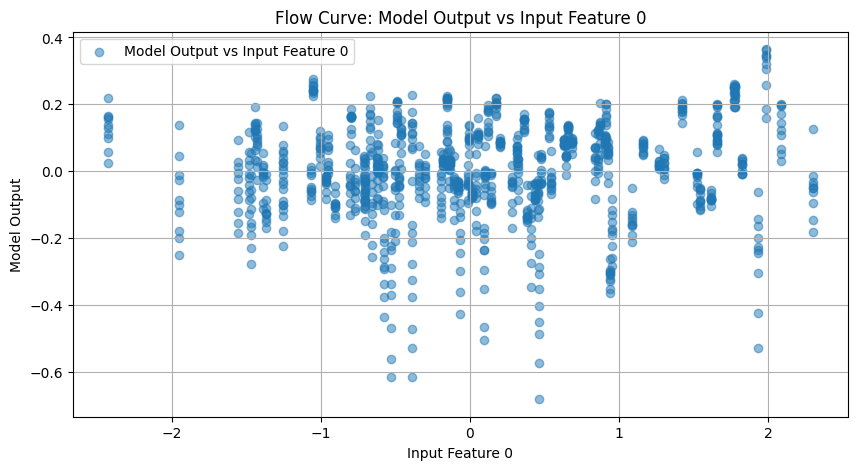

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define your NavierStokesNet (example structure)
class NavierStokesNet(nn.Module):
    def __init__(self):
        super(NavierStokesNet, self).__init__()
        self.fc1 = nn.Linear(10, 64)  # 10 input features to 64 hidden units
        self.fc2 = nn.Linear(64, 32)  # 64 hidden units to 32 hidden units
        self.fc3 = nn.Linear(32, 1)   # 32 hidden units to 1 output (regression)

    def forward(self, node_features):
        x = torch.relu(self.fc1(node_features))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize the model
model = NavierStokesNet()

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Create a dummy dataset (e.g., 100 data points with 10 features)
inputs = torch.randn(100, 10)  # 100 samples, each with 10 features
targets = torch.randn(100, 1)  # 100 target values

# Dataloader for batching
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Store data for plotting
epoch_losses = []  # To track loss over epochs
epoch_outputs = []  # To track outputs over epochs
epoch_inputs = []   # To track inputs for plotting

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_output = []
    epoch_input = []

    for batch in dataloader:
        node_features, target = batch

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output = model(node_features)

        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Collect outputs and inputs for flow curve visualization
        epoch_output.append(output.detach().numpy())
        epoch_input.append(node_features[:, 0].detach().numpy())  # Store the first feature for plotting

    # Average loss for the epoch
    epoch_losses.append(epoch_loss / len(dataloader))

    # Flatten the collected outputs and inputs for plotting
    epoch_output = np.concatenate(epoch_output, axis=0)
    epoch_input = np.concatenate(epoch_input, axis=0)

    epoch_outputs.append(epoch_output)
    epoch_inputs.append(epoch_input)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

# Convert epoch outputs and losses to numpy for plotting
epoch_losses = np.array(epoch_losses)
epoch_outputs = np.concatenate(epoch_outputs, axis=0)
epoch_inputs = np.concatenate(epoch_inputs, axis=0)

# 1. Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), epoch_losses, label='Loss over Epochs', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# 2. Plot the Flow Curve (Output vs Input Features)
# Ensure matching sizes
if len(epoch_inputs) == len(epoch_outputs):
    plt.figure(figsize=(10, 5))
    plt.scatter(epoch_inputs, epoch_outputs, alpha=0.5, label='Model Output vs Input Feature 0')
    plt.xlabel('Input Feature 0')
    plt.ylabel('Model Output')
    plt.title('Flow Curve: Model Output vs Input Feature 0')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"Mismatch between input features and outputs. Sizes: {len(epoch_inputs)} vs {len(epoch_outputs)}")


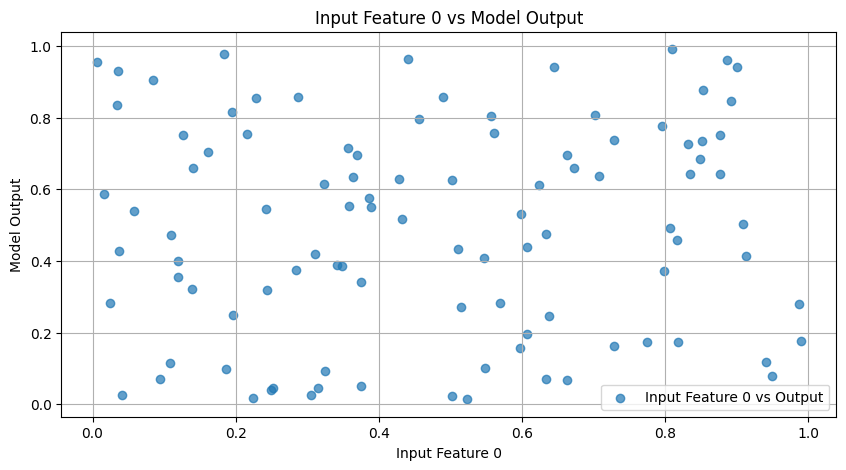

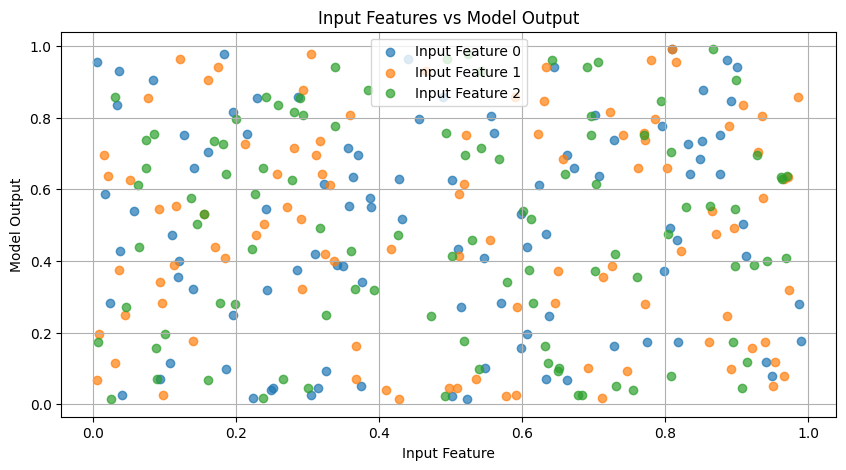

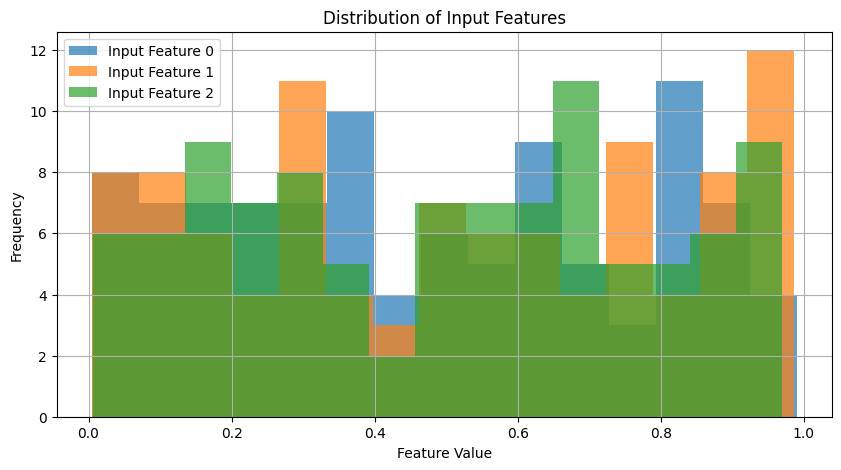

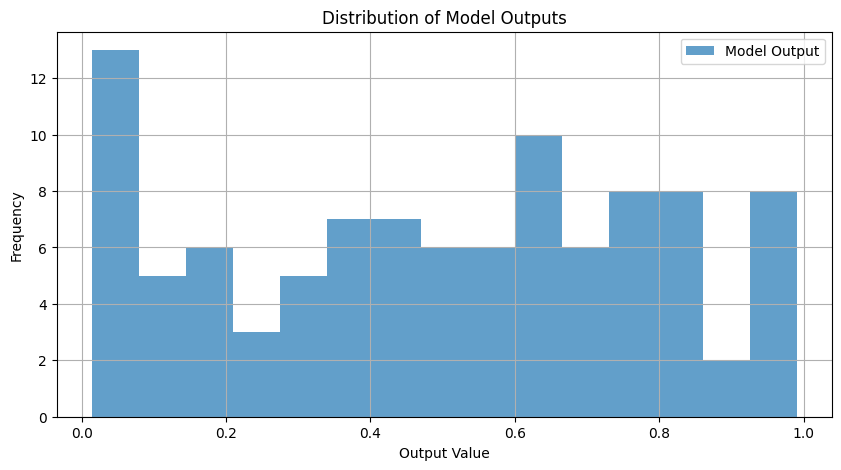

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Assuming inputs and outputs are NumPy arrays or tensors
# inputs should be of shape (num_samples, num_features), outputs should be of shape (num_samples,)

# Generating some dummy data for demonstration
np.random.seed(42)
inputs = np.random.rand(100, 3)  # 100 samples, 3 input features
outputs = np.random.rand(100)    # 100 output values

# Plot 1: Scatter plot of Input Feature vs Model Output
plt.figure(figsize=(10, 5))
plt.scatter(inputs[:, 0], outputs, alpha=0.7, label='Input Feature 0 vs Output')  # Using the first feature
plt.xlabel('Input Feature 0')
plt.ylabel('Model Output')
plt.title('Input Feature 0 vs Model Output')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Scatter plot of Input Features vs Output for all features
plt.figure(figsize=(10, 5))
for i in range(inputs.shape[1]):  # Loop through all input features
    plt.scatter(inputs[:, i], outputs, alpha=0.7, label=f'Input Feature {i}')
plt.xlabel('Input Feature')
plt.ylabel('Model Output')
plt.title('Input Features vs Model Output')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Histogram of Input Feature Distribution
plt.figure(figsize=(10, 5))
for i in range(inputs.shape[1]):
    plt.hist(inputs[:, i], bins=15, alpha=0.7, label=f'Input Feature {i}')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.title('Distribution of Input Features')
plt.legend()
plt.grid(True)
plt.show()

# Plot 4: Histogram of Output Distribution
plt.figure(figsize=(10, 5))
plt.hist(outputs, bins=15, alpha=0.7, label='Model Output')
plt.xlabel('Output Value')
plt.ylabel('Frequency')
plt.title('Distribution of Model Outputs')
plt.legend()
plt.grid(True)
plt.show()
